[ ] Fix the latent variance calculations. (I think it's just taking total variance instead of the 2 norm of z vectors.)

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import torch
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import torch.nn.functional as F

import warnings
warnings.filterwarnings("ignore")
from importlib import reload

# this ensures that I can update the class without losing my variables in my notebook
import xenium_cluster
reload(xenium_cluster)
from xenium_cluster import XeniumCluster
from utils.metrics import *

In [2]:
# Path to your .gz file
file_path = 'data/hBreast/transcripts.csv.gz'

# Read the gzipped CSV file into a DataFrame
df_transcripts = pd.read_csv(file_path, compression='gzip')
df_transcripts.head()

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv
0,281474976710657,191815,1,LUM,4797.2383,550.61346,15.421524,18.445875
1,281474976710663,214084,1,SEC11C,4801.7330,905.11600,14.925031,31.019386
2,281474976710672,191342,0,TCIM,4804.4920,596.05396,14.681485,22.270780
3,281474976710673,191574,0,STC1,4805.0483,414.38370,19.306356,16.183300
4,281474976710674,192193,0,STC1,4805.7170,273.81440,16.112896,26.251837


In [3]:
clustering = XeniumCluster(data=df_transcripts, dataset_name="hBreast")
clustering.set_spot_size(25)
clustering.create_spot_data(third_dim=False, save_data=True)

In [4]:
HIGHLY_VARIABLE = False
clustering.normalize_counts(clustering.xenium_spot_data)

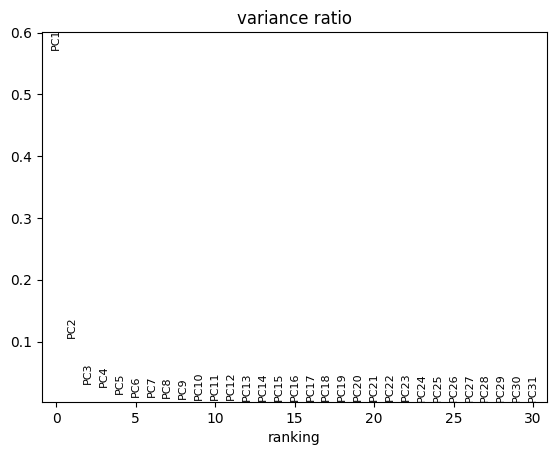

In [5]:
HIGHLY_VARIABLE = True
clustering.filter_only_high_variable_genes(clustering.xenium_spot_data)
# generate the neigborhood graph based on pca
sc.tl.pca(clustering.xenium_spot_data, svd_solver='arpack')
sc.pl.pca_variance_ratio(clustering.xenium_spot_data)
clustering.xenium_spot_data = clustering.xenium_spot_data[:,clustering.xenium_spot_data.var.highly_variable==True]

In [6]:
clustering.xenium_spot_data.var, clustering.xenium_spot_data.var.shape

(        highly_variable     means  dispersions  dispersions_norm
 ABCC11             True  0.783410     1.701554          0.671810
 ACTA2              True  1.339726     2.501664          1.074146
 ACTG2              True  0.647614     1.481535          0.261175
 ADH1B              True  0.418026     1.785759          0.952606
 AIF1               True  0.639388     1.154657         -0.409606
 ...                 ...       ...          ...               ...
 TRAF4              True  1.098693     1.437155         -0.332624
 TRIB1              True  0.760012     1.726540          0.718442
 VWF                True  0.602005     2.528375          1.879303
 ZEB1               True  0.478715     0.890358         -0.414168
 ZEB2               True  0.794795     1.363296          0.040499
 
 [95 rows x 4 columns],
 (95, 4))

In [7]:
clustering.xenium_spot_data.obs, clustering.xenium_spot_data.obs.shape

(       spot_number    x_location   y_location z_location    row    col
 0               72     25.020440  1827.517000  11.981410   72.0    0.0
 1               73     20.056494  1851.413133  11.947445   73.0    0.0
 2               74      5.284646  1873.181000  12.024776   74.0    0.0
 3               76      6.906573  1918.434600  11.887645   76.0    0.0
 4               77      6.353386  1932.939000  11.904607   77.0    0.0
 ...            ...           ...          ...        ...    ...    ...
 111707      145334  10278.613000  6301.132000  24.446114  251.0  411.0
 111708      145345  10284.986000  6567.882000  24.642742  262.0  411.0
 111709      145355  10286.389000  6829.160000  24.632755  272.0  411.0
 111710      145692  10303.937000  6412.000000  24.712805  256.0  412.0
 111711      145697  10305.357000  6548.361000  24.396360  261.0  412.0
 
 [111712 rows x 6 columns],
 (111712, 6))

In [8]:
expression_data = pd.DataFrame(clustering.xenium_spot_data.X, columns=clustering.xenium_spot_data.var.index)
clustering.xenium_spot_data.obs.index = clustering.xenium_spot_data.obs.index.astype(int)
input_data = clustering.xenium_spot_data.obs.join(expression_data)
input_data.head()

,spot_number,x_location,y_location,z_location,row,col,ABCC11,ACTA2,ACTG2,ADH1B,...,TENT5C,TFAP2A,TOMM7,TOP2A,TRAC,TRAF4,TRIB1,VWF,ZEB1,ZEB2
0,72,25.020440,1827.517000,11.981410,72.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,73,20.056494,1851.413133,11.947445,73.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,74,5.284646,1873.181000,12.024776,74.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,76,6.906573,1918.434600,11.887645,76.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,77,6.353386,1932.939000,11.904607,77.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Reconstruction Loss

Input: $X$

Reconstruction: $X^{'}$

$$(X - X^{'})^2$$

### Spatial Loss

Left Boundary $(l)$: $\max(0, j - n)$

Right Boundary $(r)$: $\min(0, j + n)$

Top Boundary $(t)$: $\max(0, i - n)$

Bottom Boundary $(b)$: $\min(0, i + n)$

$$\frac{1}{IJ} \sum_{i=1}^I \sum_{j=1}^{J} \frac{1}{(r-l+1)(b-t+1)}\sum_{i^{'} = b}^{t} \sum_{j^{'}=l}^{r} D_{KL}(C[i^{'}, j^{'}], C[i, j]) $$

### Entropy Regularization

$$- \frac{1}{IJK} \sum_{i=1}^{I}\sum_{j=1}^{J}\sum_{k=1}^{K} p_{i,j}(k) \log(p_{i,j}(k)) $$

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "[1]"


In [10]:
class GumbelSoftmax(torch.nn.Module):
    def __init__(self, dim, temperature=1.0):
        super(GumbelSoftmax, self).__init__()
        self.dim = dim
        self.temperature = temperature

    def forward(self, logits):
        return F.gumbel_softmax(logits, tau=self.temperature, dim=self.dim)

    def extra_repr(self):
        return f'temperature={self.temperature}'

In [151]:
class ClassifierAutoEncoder(L.LightningModule):

    def __init__(
            self,
            spot_height,
            spot_width,
            spot_depth = None,
            within_cluster_distance_hyperparam = 1,
            within_cluster_penalty_hyperparam = 1, 
            spatial_penalty_hyperparam = 1,
            entropy_penalty_hyperparam = 1,
            cluster_util_penalty_hyperparam = 1,
            neighborhood_size = 5,
            num_clusters = 10,
            latent_dim = 10
        ):

        self.within_cluster_distance_hyperparam = within_cluster_distance_hyperparam
        self.within_cluster_penalty_hyperparam = within_cluster_penalty_hyperparam
        self.spatial_penalty_hyperparam = spatial_penalty_hyperparam
        self.entropy_penalty_hyperparam = entropy_penalty_hyperparam
        self.cluster_util_penalty_hyperparam = cluster_util_penalty_hyperparam
        self.neighborhood_size = neighborhood_size
        self.num_clusters = num_clusters
        self.input_size = 95 if HIGHLY_VARIABLE else 541
        self.kernel_size = 5
        self.stride = 2
        self.padding = 0
        self.spot_height = spot_height
        self.spot_width = spot_width
        self.spot_depth = spot_depth
        self.latent_dim = latent_dim

        self.loss_array = []
        self.reconstruction = []
        self.wcd = []
        self.wcl = []

        super(ClassifierAutoEncoder, self).__init__()

        # Encoder Layers
        self.enc_conv1 = torch.nn.Conv2d(self.input_size, 256, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        self.enc_batchnorm1 = torch.nn.BatchNorm2d(256)
        self.enc_conv2 = torch.nn.Conv2d(256, 256, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        self.enc_batchnorm2 = torch.nn.BatchNorm2d(256)
        self.enc_conv3 = torch.nn.Conv2d(256, self.latent_dim, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        self.enc_batchnorm3 = torch.nn.BatchNorm2d(self.latent_dim)
        self.enc_pool = torch.nn.AdaptiveAvgPool2d((25, 25))

        # Decoder Layers
        self.dec_conv1 = torch.nn.ConvTranspose2d(self.latent_dim, 256, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        self.dec_batchnorm1 = torch.nn.BatchNorm2d(256)
        self.dec_conv2 = torch.nn.ConvTranspose2d(256, 256, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        self.dec_batchnorm2 = torch.nn.BatchNorm2d(256)
        self.dec_conv3 = torch.nn.ConvTranspose2d(256, self.input_size, kernel_size=self.kernel_size, padding=self.padding, stride=self.stride)
        self.dec_batchnorm3 = torch.nn.BatchNorm2d(self.input_size)

        self.activation = torch.nn.LeakyReLU()

        # Bridging Layers
        self.upsample = torch.nn.Upsample((self.spot_height, self.spot_width), mode='bilinear', align_corners=False)

        # Cluster Layers
        self.clust_linear1 = torch.nn.Linear(self.latent_dim, 256)
        self.clust_linear2 = torch.nn.Linear(256, 128)
        self.clust_linear3 = torch.nn.Linear(128, self.num_clusters)
        self.clust_softmax = GumbelSoftmax(dim=1)

        self.encoder = torch.nn.Sequential(
            self.enc_conv1,
            self.enc_batchnorm1,
            self.activation,
            self.enc_conv2, 
            self.enc_batchnorm2,   
            self.activation,       
            self.enc_conv3,  
            self.enc_batchnorm3,
            self.enc_pool    
        )

        self.decoder = torch.nn.Sequential(
            self.dec_conv1,
            self.dec_batchnorm1,
            self.activation,
            self.dec_conv2, 
            self.dec_batchnorm2,
            self.activation,
            self.dec_conv3, 
            self.dec_batchnorm3,
        )

        self.cluster_assignment = torch.nn.Sequential(
            self.clust_linear1,
            self.activation,
            self.clust_linear2,
            self.activation,
            self.clust_linear3,
            self.clust_softmax 
        )
        
    def training_step(self, batch, batch_idx):

        x, x_hat, z, cluster = self(batch)

        try:
            zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

            # Apply mask to input and reconstruction
            x_masked = x * zeros
            x_hat_masked = x_hat * zeros
            z_masked = z * torch.flatten(zeros).view(-1,1)
            cluster_masked = cluster * torch.flatten(zeros).view(-1,1)
        except:
            # Apply mask to input and reconstruction
            x_masked = x
            x_hat_masked = x_hat
            z_masked = z
            cluster_masked = cluster
            print("The masking procedure did not work.")

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        formatted_loss = round(loss.item(), 4)
        print(formatted_loss)
        self.loss_array.append(formatted_loss)
        print(f"# of Clusters: {cluster_masked.argmax(dim=1).unique().numel()}")

        return loss

    def validation_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        try:
            zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

            # Apply mask to input and reconstruction
            x_masked = x * zeros
            x_hat_masked = x_hat * zeros
            z_masked = z * torch.flatten(zeros).view(-1,1)
            cluster_masked = cluster * torch.flatten(zeros).view(-1,1)
        except:
            # Apply mask to input and reconstruction
            x_masked = x
            x_hat_masked = x_hat
            z_masked = z
            cluster_masked = cluster
            print("The masking procedure did not work.")

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        return loss

    def test_step(self, batch, batch_idx):
        x, x_hat, z, cluster = self(batch)
        try:
            zeros = self.training_mask(x).unsqueeze(0).unsqueeze(0)

            # Apply mask to input and reconstruction
            x_masked = x * zeros
            x_hat_masked = x_hat * zeros
            z_masked = z * torch.flatten(zeros).view(-1,1)
            cluster_masked = cluster * torch.flatten(zeros).view(-1,1)
        except:
            # Apply mask to input and reconstruction
            x_masked = x
            x_hat_masked = x_hat
            z_masked = z
            cluster_masked = cluster
            print("The masking procedure did not work.")

        loss = self.spatial_loss_function(x_masked, x_hat_masked, z_masked, cluster_masked)

        return loss


    def spatial_loss_function(self, input, reconstruction, latents, cluster_probabilities):
        reconstruction_loss = F.mse_loss(input, reconstruction)
        within_cluster_penalty = self.within_cluster_average_latent_dissimilarity(latents, cluster_probabilities)
        spatial_cluster_penalty = self.neighboring_cluster_dissimilarity(cluster_probabilities, input)
        within_cluster_distance = self.within_cluster_distance(cluster_probabilities, input)
        print(f"""LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial)
              ({reconstruction_loss}, {self.within_cluster_penalty_hyperparam * within_cluster_penalty}, {self.within_cluster_distance_hyperparam * within_cluster_distance}, {self.spatial_penalty_hyperparam * spatial_cluster_penalty})
              """)
        self.reconstruction.append(reconstruction_loss.item())
        self.wcd.append(within_cluster_distance.item())
        self.wcl.append(within_cluster_penalty.item())
        # return self.within_cluster_distance_hyperparam * within_cluster_distance
        return reconstruction_loss + self.within_cluster_distance_hyperparam * within_cluster_distance
        return reconstruction_loss + self.within_cluster_penalty_hyperparam * within_cluster_penalty + self.within_cluster_distance_hyperparam * within_cluster_distance


    def within_cluster_average_latent_dissimilarity(self, z, cluster_probabilities, min_utilization_penalty=0.25):
        cluster_assignments = cluster_probabilities.argmax(dim=1)
        num_clusters = cluster_probabilities.shape[1]

        # Compute the mean latent representation for each cluster
        cluster_means = torch.stack([z[cluster_assignments == i].mean(dim=0) if (cluster_assignments == i).any() else torch.zeros_like(z[0]) for i in range(num_clusters)])

        # Calculate the dissimilarity as the mean squared distance from each point to its cluster mean
        dissimilarity_loss = 0.0
        for i in range(num_clusters):
            cluster_points = z[cluster_assignments == i]
            if cluster_points.nelement() > 0:
                dissimilarity_loss += (cluster_points - cluster_means[i]).pow(2).mean()

        # Normalize by the number of clusters
        dissimilarity_loss /= num_clusters

        # total_loss = dissimilarity_loss
        # Utilization penalty: Soft minimum average probability per cluster
        average_cluster_probs = cluster_probabilities.mean(dim=0)  # Mean probability assigned to each cluster across all data points
        utilization_penalty = -torch.log(average_cluster_probs.clamp(min=1e-6)).mean()  # Soft penalty using negative log

        print(f"DISSIMILARITY, PENALTY - {dissimilarity_loss}, {min_utilization_penalty * utilization_penalty}")
        total_loss = dissimilarity_loss + min_utilization_penalty * utilization_penalty

        return total_loss


    def within_cluster_distance(self, cluster_probabilities, x, balance_coeff=25.):
        """
        Calculates a clustering loss which minimizes intra-cluster distance and maximizes inter-cluster distance.
        
        Parameters:
        - cluster_probabilities (torch.Tensor): Tensor of shape (num_spots, num_clusters)
            representing the probability of each data point belonging to each cluster.
        - x (torch.Tensor): Tensor of data points of shape (batch, channels, height, width).
        
        Returns:
        - torch.Tensor: The computed loss.
        """

        # Assuming spatial coordinates can be derived from the last two dimensions (height, width)
        _, _, H, W = x.shape
        spatial_coords = torch.stack(torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij'), dim=-1)
        spatial_coords = spatial_coords.float().to(x.device)  # Convert coordinates to float and send to device
        spatial_coords_flat = spatial_coords.view(-1, 2)  # Flatten the coordinates

        # Calculate centroids of clusters in spatial terms
        weighted_spatial_sum = torch.mm(cluster_probabilities.t(), spatial_coords_flat)
        cluster_sizes = cluster_probabilities.sum(dim=0, keepdim=True).t()
        spatial_centroids = weighted_spatial_sum / cluster_sizes

        # Intra-cluster variance (minimize)
        expanded_probs = cluster_probabilities.unsqueeze(2)
        expanded_spatial_centroids = spatial_centroids.unsqueeze(0)
        dists_to_spatial_centroids = torch.norm(spatial_coords_flat.unsqueeze(1) - expanded_spatial_centroids, dim=2, p=2)
        intra_cluster_variance = torch.mean(expanded_probs.squeeze() * (dists_to_spatial_centroids ** 2))

        # Inter-cluster variance (maximize)
        spatial_centroid_dists = torch.pdist(spatial_centroids, p=2)
        inter_cluster_variance = spatial_centroid_dists.mean()

        # Combine the losses
        print(f"INTRA, INTER - {intra_cluster_variance}, {balance_coeff / inter_cluster_variance}")
        loss = intra_cluster_variance + (balance_coeff / inter_cluster_variance)

        return loss

    
    def neighboring_cluster_dissimilarity(self, cluster, x, zero_correction = 1e-9):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster.shape
        spatial_cluster = cluster.view(height, width, num_clusters)
        dissimilarity_values = []
        for i in range(height):
            for j in range(width):

                left_boundary = max(0, j - self.neighborhood_size)
                right_boundary = min(width, j + self.neighborhood_size + 1)
                top_boundary = max(0, i - self.neighborhood_size)
                bottom_boundary = min(height, i + self.neighborhood_size + 1)
                neighborhood = spatial_cluster[top_boundary:bottom_boundary, left_boundary:right_boundary]

                central_pixel_distr = spatial_cluster[i, j, :].unsqueeze(0).unsqueeze(0)
                kl_divergences = F.kl_div((central_pixel_distr + zero_correction).log(), neighborhood + zero_correction, reduction='none', log_target=False)
                dissimilarity = kl_divergences.sum(dim=-1).mean(dim=(0, 1))

                dissimilarity_values.append(dissimilarity.unsqueeze(0))

        dissimilarities = torch.cat(dissimilarity_values).to(x.device)
        return torch.mean(dissimilarities)  
    
    def entropy_regularization(self, cluster_probs, x, zero_correction = 1e-9):
        batch, channels, height, width = x.shape
        spots, num_clusters = cluster_probs.shape
        spatial_cluster = cluster_probs.view(height, width, num_clusters)
        entropy = -torch.sum(spatial_cluster * torch.log(spatial_cluster + zero_correction), dim=2)
        entropy_loss = torch.mean(entropy)
        return entropy_loss

    def forward(self, x):

        batch_size, _, _, _ = x.shape

        z = self.encoder(x)
        # FIX THIS TO BE FOR SEVERAL BATCHES
        x_hat = self.upsample(self.decoder(z))
        z = self.upsample(z)
        z = z.view(batch_size * self.spot_height * self.spot_width, self.latent_dim)
        cluster = self.cluster_assignment(z)

        return x, x_hat, z, cluster

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=5e-3)
        return optimizer

In [152]:
gene_data = []

for gene in clustering.xenium_spot_data.var.index:
    gene_channel = pd.pivot(input_data, index = 'row', columns = 'col', values = f"{gene}").fillna(0)
    gene_tensor = torch.tensor(gene_channel.to_numpy())
    gene_data.append(gene_tensor)

input_tensor = torch.stack(gene_data, dim=0)
input_tensor.shape

torch.Size([95, 352, 413])

In [153]:
channels, spot_height, spot_width = input_tensor.shape
input_tensor = input_tensor.float()
input_tensor.to(dtype=torch.float32)
print(input_tensor.shape)
dataset = [input_tensor]
dataloader = DataLoader(dataset, batch_size=1)

model = ClassifierAutoEncoder(spot_height, spot_width, num_clusters=10, latent_dim=10, entropy_penalty_hyperparam = 1, within_cluster_distance_hyperparam = 1e-3, within_cluster_penalty_hyperparam = 2.5, spatial_penalty_hyperparam = 0.01, cluster_util_penalty_hyperparam = 1, neighborhood_size = 4)

torch.Size([95, 352, 413])


In [154]:
trainer = L.Trainer(max_epochs=500)
trainer.fit(model=model, train_dataloaders=dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

   | Name               | Type              | Params
----------------------------------------------------------
0  | enc_conv1          | Conv2d            | 608 K 
1  | enc_batchnorm1     | BatchNorm2d       | 512   
2  | enc_conv2          | Conv2d            | 1.6 M 
3  | enc_batchnorm2     | BatchNorm2d       | 512   
4  | enc_conv3          | Conv2d            | 64.0 K
5  | enc_batchnorm3     | BatchNorm2d       | 20    
6  | enc_pool           | AdaptiveAvgPool2d | 0     
7  | dec_conv1          | ConvTranspose2d   | 64.3 K
8  | dec_batchnorm1     | BatchNorm2d       | 512   
9  | dec_conv2          | ConvTranspose2d   | 1.6 M 
10 | dec_batchnorm2     | BatchNorm2d       | 512   
11 | dec_conv3          | ConvTranspose2d   | 608 K 
12 | dec_batchnorm3     | BatchNorm2d       | 190   
13 | activation         | LeakyReLU         | 0    

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s] 

The masking procedure did not work.
DISSIMILARITY, PENALTY - 0.24743227660655975, 0.57591712474823
INTRA, INTER - 2453.889404296875, 31.495878219604492
LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial)
              (1.3425406217575073, 2.05837345123291, 2.4853854179382324, 0.015581979416310787)
              
3.8279
# of Clusters: 10
Epoch 1:   0%|          | 0/1 [00:00<?, ?it/s, v_num=43]        The masking procedure did not work.
DISSIMILARITY, PENALTY - 0.6477657556533813, 0.578786313533783
INTRA, INTER - 2453.8740234375, 25.765520095825195
LOSS CONTRIBUTIONS: 
              (Reconstruct, Within, Within Distance, Spatial)
              (1.1232037544250488, 3.066380023956299, 2.479639768600464, 0.015564728528261185)
              
3.6028
# of Clusters: 10
Epoch 2:   0%|          | 0/1 [00:00<?, ?it/s, v_num=43]        The masking procedure did not work.
DISSIMILARITY, PENALTY - 0.7537769675254822, 0.5892787575721741
INTRA, INTER - 2453.821533203125, 

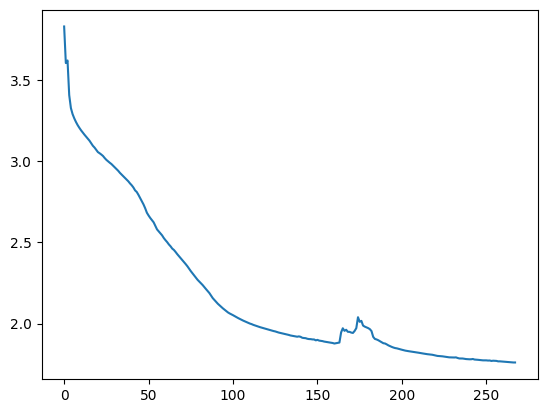

In [155]:
plt.plot(range(len(model.loss_array)), model.loss_array)

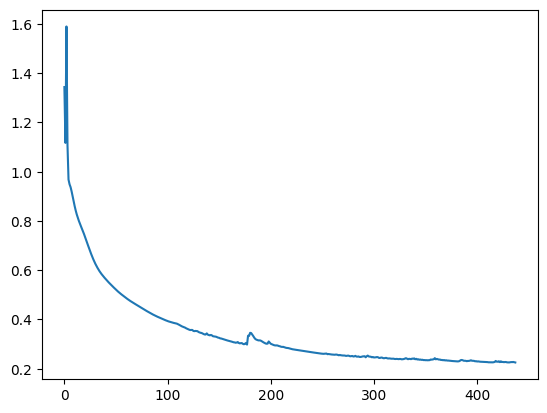

In [140]:
plt.plot(range(len(model.reconstruction)), model.reconstruction)

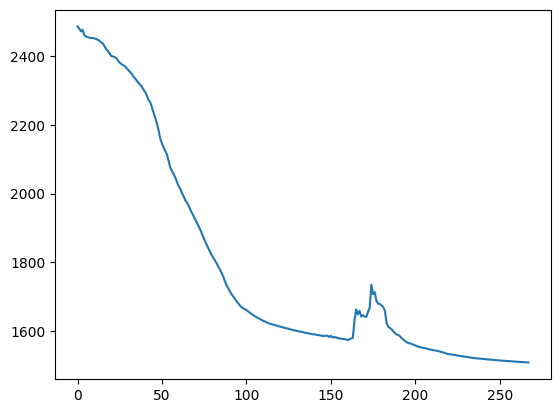

In [156]:
plt.plot(range(len(model.wcd)), model.wcd)

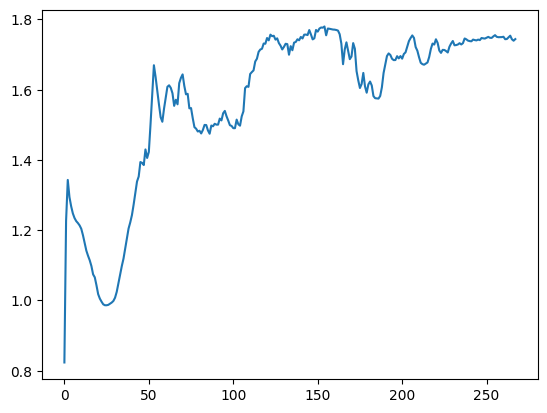

In [157]:
plt.plot(range(len(model.wcl)), model.wcl)

In [158]:
predictions = trainer.predict(model = model, dataloaders = dataloader)

Predicting DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

Predicting DataLoader 0: 100%|██████████| 1/1 [00:01<00:00,  0.76it/s]


In [159]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
clusters

tensor([[6.0467e-18, 1.8001e-04, 1.7887e-17,  ..., 9.9982e-01, 0.0000e+00,
         5.1546e-08],
        [8.2992e-18, 6.6417e-05, 5.0636e-18,  ..., 9.9993e-01, 0.0000e+00,
         3.8486e-09],
        [5.1655e-18, 1.0922e-03, 5.8008e-17,  ..., 9.9891e-01, 0.0000e+00,
         5.4164e-08],
        ...,
        [0.0000e+00, 6.0493e-39, 4.0418e-34,  ..., 0.0000e+00, 9.9999e-01,
         1.7678e-36],
        [0.0000e+00, 2.0203e-38, 5.7648e-35,  ..., 0.0000e+00, 1.0000e+00,
         3.7318e-37],
        [0.0000e+00, 9.8763e-37, 3.9406e-35,  ..., 0.0000e+00, 1.0000e+00,
         7.4925e-38]])

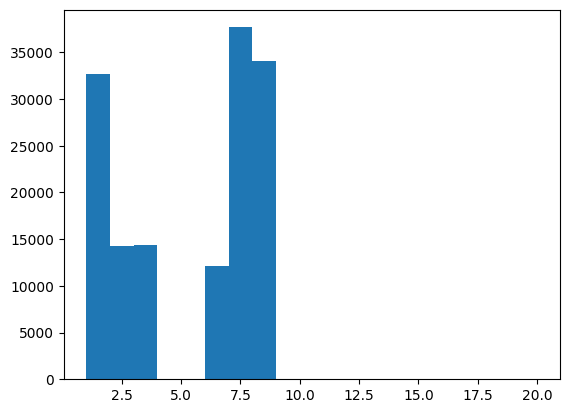

In [160]:
clusters.argmax(dim=1)
_ = plt.hist(clusters.argmax(dim=1), bins=range(1, 21))

In [161]:
inputs.shape

torch.Size([1, 95, 352, 413])

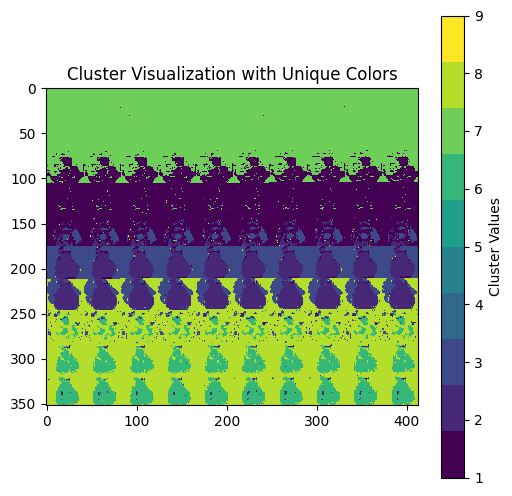

In [162]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
num_possible_clusters = clusters.shape[1]

# Get unique values and create a colormap
batch, channels, height, width = inputs.shape
clusters = clusters.argmax(dim=1).view(height, width)
clusters_np = clusters.numpy()

colors = plt.cm.get_cmap('viridis', num_possible_clusters)
colormap = ListedColormap(colors(np.linspace(0, 1, num_possible_clusters)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(clusters_np, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

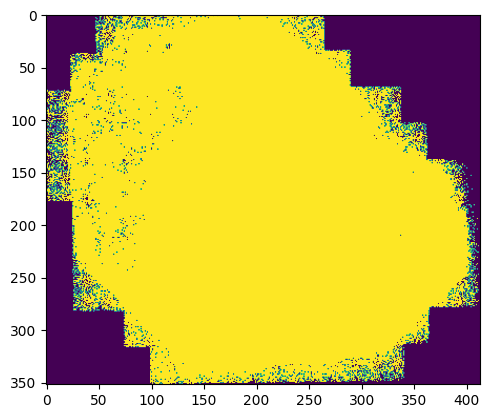

In [163]:
zeros = inputs.view(channels, height, width)
zeros = (zeros.sum(dim=0) != 0)
zeros = torch.tensor(zeros, dtype=int)

plt.imshow(zeros)

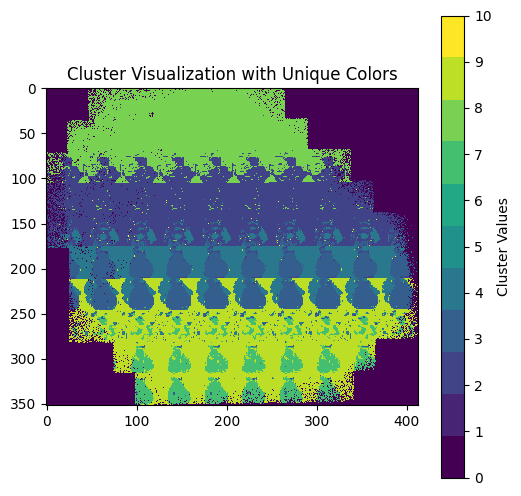

In [164]:
# Plot the tensor
inputs, reconstruction, latents, clusters = predictions[0]
num_possible_clusters = clusters.shape[1] + 1

# Get unique values and create a colormap
batch, channels, height, width = inputs.shape
zeros = inputs.view(channels, height, width)
zeros = (zeros.sum(dim=0) != 0)
zeros = torch.tensor(zeros, dtype=int)
clusters = clusters.argmax(dim=1).view(height, width)
clusters = (clusters + 1) * zeros
clusters_np = clusters.numpy()

colors = plt.cm.get_cmap('viridis', num_possible_clusters)
colormap = ListedColormap(colors(np.linspace(0, 1, num_possible_clusters)))

# Plotting
plt.figure(figsize=(6, 6))
plt.imshow(clusters_np, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Cluster Visualization with Unique Colors')
plt.show()

Text(0.5, 1.0, 'Reconstruction Values')

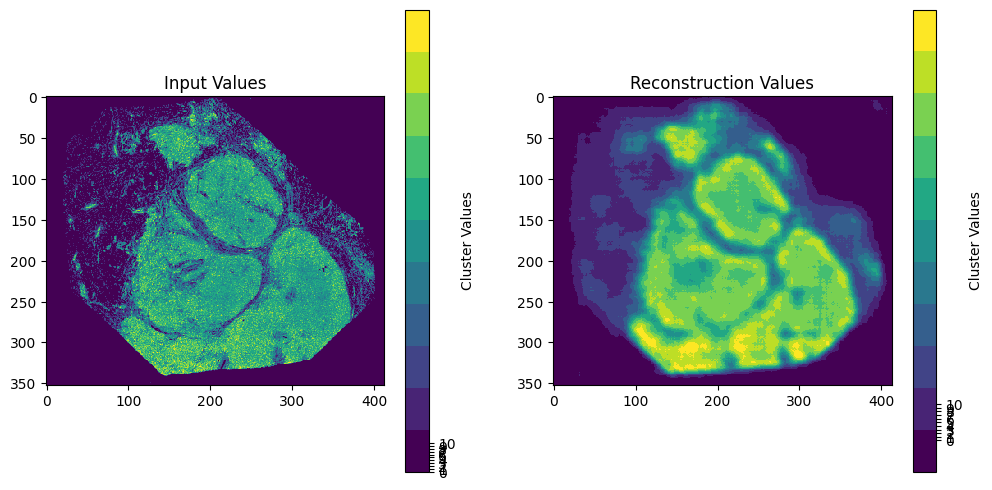

In [165]:
vis_inputs = inputs.squeeze(0).sum(dim=0)

# Setup a figure for subplots
plt.figure(figsize=(12, 6))  # Adjust the figure size as necessary

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.imshow(vis_inputs, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Input Values')

vis_reconstruction = reconstruction.squeeze(0).sum(dim=0)

plt.subplot(1, 2, 2)
plt.imshow(vis_reconstruction, cmap=colormap, interpolation='nearest')
plt.colorbar(ticks=range(num_possible_clusters), label='Cluster Values')
plt.title('Reconstruction Values')

Try: Contrastive Loss

Include: Post-Processing Clean Up (like Graph Cut or Markov Random Fields)

1. Neighborhood Size and Spatial Penalty
     - Conditional Random Fields
2. Loss Function Weights

      - Hyperparameter Tuning: Review the weights (within_cluster_distance_hyperparam, within_cluster_penalty_hyperparam, spatial_penalty_hyperparam, entropy_penalty_hyperparam, cluster_util_penalty_hyperparam) assigned to each component of the loss function. Experiment with these to see if increasing the weight of the spatial penalty helps improve spatial coherence.

3. Clustering Mechanism and Output Layer
     - Increase the latent dimension (originally was 15).
4. Data Preprocessing and Batch Effects
Make sure that the input data is appropriately preprocessed and normalized. Variations in data scaling or the presence of outliers can adversely affect clustering performance.


1. Modifying Convolutional Kernel Size and Stride
     - Smaller kernels.
     - Larger strides.

2. Incorporating Dilated Convolutions
Dilated convolutions can help expand the receptive field without increasing the direct overlap of the convolution kernels. This approach allows the model to integrate spatial context from a broader area without necessarily forcing close-by pixels to share similar feature representations as strongly as standard convolutions do.

3. Advanced Architectural Changes
Incorporating elements that specifically address the preservation of spatial boundaries, such as CRFs (Conditional Random Fields) integrated within or after the deep learning model, can significantly enhance the ability to maintain clear and meaningful cluster boundaries. CRFs are particularly adept at modeling spatial relationships and can enforce cluster boundary consistency more effectively.

 Use Strided Convolutions for Downsampling
Instead of traditional pooling layers, you can use strided convolutions to reduce spatial dimensions. This method effectively reduces the height and width while increasing the depth (number of channels), which compensates for the reduced spatial resolution by capturing more detailed feature information in the channel dimension.

Upsampling in Decoder: In the decoder, you can use transposed convolutions (often called deconvolutions) with appropriate stride to upsample the spatial dimensions back to the original size.
2. Incorporate Dilated Convolutions
Dilated convolutions allow you to expand the receptive field without reducing the spatial dimension of the output. This technique can be particularly useful if you want to capture broader context without losing resolution.

3. Max-Pooling with Indices (Max-Unpooling)
A specific technique that can be helpful is max-pooling with indices, often used in segmentation tasks:

Max-Pooling with Indices: This type of pooling keeps track of the positions of the maxima within each pooling window. This information is then used during the upsampling phase to place the values back into their original locations, allowing for precise reconstruction.
Max-Unpooling: In the decoder, use the stored indices to perform max-unpooling, which restores the data to its original dimensions by placing the max values back into their recorded positions, while other values are typically set to zero.
4. PixelShuffle for Upsampling
The PixelShuffle operation is an efficient and simple way to increase the resolution of an image or feature map. It works by rearranging elements from a low-resolution input into a high-resolution output, by reshuffling the tensor dimensions:

Increase Channels Instead of Downsampling: Modify the encoder to increase the number of channels rather than reducing the spatial dimensions. Then, in the decoder, use PixelShuffle to reduce the channel depth while increasing the spatial dimensions back to the original.
5. Bottleneck Layers
Consider using bottleneck layers that first increase the channel dimensions (deepen) and then reduce them back:

Implementation: Use 1x1 convolutions to expand the channel dimensions followed by 3x3 convolutions to process features, then another 1x1 convolution to compress the channels back. This method helps in capturing complex features without changing the spatial dimensions.
6. Using Convolutional Layers with Padding and Custom Dilation
Use a combination of custom dilation and padding settings to adjust how the field of view of each convolutional operation is spread across the input:

Custom Settings: By adjusting dilation and padding, you can manage to capture more contextual information without necessarily having to pool and thus reduce the spatial dimensions.